# Regression Models to Predict Housing Prices 

This project was inspired by the House Prices competition on Kaggle. Using the same dataset with 79 features, I attempted to build up a full Machine Learning project cycle that can be used as a baseline for similar regression problems in the future.

## 1) Data Preparation

In [332]:
import warnings
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

In [197]:
df_train = pd.read_csv(Path("./data/train.csv"))
df_test  = pd.read_csv(Path("./data/test.csv"))
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [198]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [303]:
list(df_train.columns)

['MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'Enc

## 2) Data Wrangling

Id column is unnecessary since we have an index already. Let's remove it. 

In [199]:
df_train.drop(labels=['Id'], axis=1, inplace=True)
df_test.drop(labels=['Id'], axis=1, inplace=True)

Let's separate features from the label column:

In [200]:
X_train = df_train[df_train.columns.difference(['SalePrice'])]
y_train = df_train['SalePrice']

X_test = df_test.copy()

And count the number of features.

In [201]:
total_feature_num = len(X_train.columns)
print("The number of features in the dataset: ", total_feature_num)

The number of features in the dataset:  79


Determining the number of categorical and numerical features:

In [202]:
numeric_cols   = X_train._get_numeric_data().columns
categoric_cols = X_train[X_train.columns.difference(numeric_cols)].columns
assert len(numeric_cols) + len(categoric_cols) == total_feature_num
print(f"There are {len(categoric_cols)} categorical and {len(numeric_cols)} numerical features.")

There are 43 categorical and 36 numerical features.


### 2.1) Duplicate values
In real world applications it happens very often that some records are duplicated. In such cases it is best practice to remove such doubled instances as they would skew our models later in the process. Let's see if this problem affects us now:

In [214]:
X_train.duplicated().sum()

0

Nope! There are no duplicate values present.

### 2.2) Missing values

Now we'll check for missing values. First and foremost, let's check if the output variable (*SalePrice*) has missing values. It certainly shouldn't have - but in case it does have, we might want to consider appending them to the test set. 

In [215]:
y_train.isnull().sum()

0

No missing values are present in the output variable's column. Next step is to check the feature columns. For that, let's create an ordered series showing the percentage of missing values for each of the features in descending order to have a clear view on the extent of the problem with missing data:

In [204]:
sorted_missing_pct = (X_train.isnull().sum() / X_train.shape[0] * 100).sort_values(ascending=False)
sorted_missing_pct.name = 'missing_pct'
categorical_or_numerical = pd.Series(['cat' if var in categoric_cols else 'num' for var in sorted_missing_pct.index],
         index = sorted_missing_pct.index,
         name = 'categorical_or_numerical')

feature_info = pd.concat([sorted_missing_pct, categorical_or_numerical], axis=1)
feature_info[feature_info['missing_pct'] != 0.0]

,missing_pct,categorical_or_numerical
PoolQC,99.520548,cat
MiscFeature,96.301370,cat
Alley,93.767123,cat
Fence,80.753425,cat
FireplaceQu,47.260274,cat
LotFrontage,17.739726,num
GarageFinish,5.547945,cat
GarageCond,5.547945,cat
GarageQual,5.547945,cat
GarageYrBlt,5.547945,num


19 features out of 80 have missing values and 4 out of them have more than 80% of the data missing! We now also know that out of these 19 features, only 3 are numerical, the rest are categorical features. There are multiple possible options on how to deal with such columns:
 * dropping columns which have more missing values than an input threshold (e.g. 25%),
 * imputing data with mean/median (for continuous variables) or most common category (for categorical variables),
 * alternatively, approximating the categorical distribution and generating values randomly to impute missing data,
 * finally, if there is sufficient evidence for the missing data to have an extra meaning, they can be treated as a separate value (e.g. 0, for continuous variables) or as a separate category (e.g. 'does not exist', 'not applicable' category).
 
While there are several possible approaches we could take, let's first notice that certain variables have exactly the same percentage of missing values, implying that they are most probably related: 
 * all Garage variables have the same percentage of missing values, i.e. we can logically assume that for 5.55% of records there was no garage present
 * same logic as before for Vnr variables (veneer): MasVnrArea, MasVnrType
 * there is a slight irregularity regarding the basement variables (Bsmt): BsmtExposure and BsmtFinType2 have marginally more missing values than the rest - we'll need to investigate this in a bit. 
 * for the rest, it is safe to assume that a missing value means the given feature did not exist for the household, i.e. no pool (PoolQC), no other miscellaneous feature (MiscFeature), no alley (Alley), no fence (Fence), no fireplace (FireplaceQu), no lot frontage i.e. household doesn't have a direct frontage on the street (LotFrontage), and no electricity (Electrical), this latter being extremely small percentage, a mere 0.07%, as expected. 
 
Therefore we can surely treat almost all missing variables as meaningful information, we only need to examine the above mentioned irregularity with the basement (Bsmt) features.

In [205]:
bsmt_examine = X_train[(X_train['BsmtExposure'].isnull() | X_train['BsmtFinType2'].isnull()) & (~X_train['BsmtCond'].isnull() | ~X_train['BsmtFinType1'].isnull() | ~X_train['BsmtQual'].isnull())]
bsmt_examine[[col for col in bsmt_examine.columns if 'Bsmt' in col]]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
332,TA,No,1124,479,GLQ,NaN,1,0,Gd,1603,3206
948,TA,NaN,0,0,Unf,Unf,0,0,Gd,936,936


In [206]:
#X_train[(X_train['BsmtFinSF1']==0) & (X_train['BsmtFinType1']!='Unf')][['BsmtFinSF1', 'BsmtFinType1']]
#X_train[(X_train['BsmtFinSF2']==0) & (X_train['BsmtFinType2']!='Unf')][['BsmtFinSF2', 'BsmtFinType2']]

Luckily, there are only two records that seem suspicious, i.e. where either *BsmtExposure* or *BsmtFinType2* is missing while any of the other basement features having valid data. According to the subject experts, a missing data in either of the basement columns means "no basement." In the above two records, however, there is a contradiction: for record #332, *BsmtFinType2* suggests "no basement" while there is clearly a basement since all other parameters imply an existing basement, and similarly, for record #948, *BsmtExposure* suggests "no basement" while all other parameters imply an existing basement. The easy way would be to just drop these two records, as they represent less than 0.2% of our total training set (2 out of 1460 records). However, how would we handle the problem if much more records were affected?

#### Analyzing Record #332
*BsmtFinType2* is a missing value, while it is absolutely certain that the basement exists. We furthermore know from *BsmtFinType1* and *BsmtFinSF1* that 1124 sq. feet of the basement has been finished and its rating is GLQ (good living quarters). From *BsmtFinSF2* we know that an additional 479 sq. feet was also recorded separately from the *BsmtUnfSF* (Basement unfinished square feet), implying that *BsmtFinType2* is definitely not 'Unf' (unfinished). Other potential values for the *BsmtFinType2* feature are BLQ, ALQ, Rec, LwQ, and GLQ. Let's check the frequency of each among those records where *BsmtFinType2* is neither 'Unf' (unfinished) nor missing:

In [207]:
X_train[(X_train['BsmtFinType2']!='Unf') & (~X_train['BsmtFinType2'].isnull())]['BsmtFinType2'].value_counts()

Rec    54
LwQ    46
BLQ    33
ALQ    19
GLQ    14
Name: BsmtFinType2, dtype: int64

The variation is quite large and it's not possible to impute the missing value by taking the most common category, since the most common category (Rec) covers less than one third of the records (32.5%). In this case, imputation is not possible and hence, we have no other option than to drop the record. 

In [208]:
X_train = X_train.drop(labels=[332])

#### Analyzing Record #948
Record #948 is less complicated. We can see that the total basement area is entirely unfinished yet, and this fact is well confirmed by *BsmtFinSF1*, *BsmtFinSF2*, *BsmtFinType1*, *BsmtFinType2* features. The missing *BsmtExposure* value thus clearly cannot mean "no basement" but rather "no basement exposure" where exposure refers to basement walkout towards the garden. But before imputing the value, let's see the value counts of the feature:

In [211]:
X_train['BsmtExposure'].value_counts()

No    952
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

Albeit not entirely certain, we can reasonably argue to impute record #948 with the most frequent category, the category that would logically make sense too: that there is "no basement exposure." Let's do so:

In [212]:
X_train.loc[948, 'BsmtExposure'] = 'No'

We have successfully finished the handling of missing values. The rest of the missing values are meaningful as confirmed by subject experts and hence will later be used as separate categories or values. 

## 3) Exploratory Data Analysis (EDA)

### 3.1) Univariate Analysis of Target Variable

Let's first explore the target variable, *SalePrice* using various statistical parameters.

In [222]:
y_train.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Great! At first sight there are no nonsensical values such as a zero- or negative-valued housing. But there might be some skew involved, since the 50th percentile is at 163,000 while the mean is significantly above, at around 181,000. Let's confirm this by plotting *SalePrice* on a histogram:

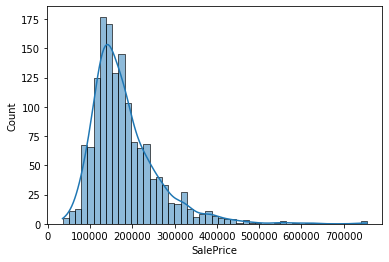

In [253]:
sns.histplot(y_train, kde=True);

That's indeed a heavily skewed target variable and definitely doesn't look too close to a Gaussian distribution. We can quantify the extent of *SalePrice*'s divergence from "normality" by computing its skewness and kurtosis:  

In [250]:
print(f"SalePrice has a skewness of {y_train.skew()} and a kurtosis of {y_train.kurt()}.")

SalePrice has a skewness of 1.8828757597682129 and a kurtosis of 6.536281860064529.


A Gaussian distribution has a skewness of 0 and kurtosis of 3 which is very far from the characteristics of our target variable at the moment. The target variable is positively skewed and is more peaked than the normal distribution.  We might also want to plot the target variable on a box and whisker plot to visually see the range of *SalePrice*s and the likely outliers. A box and whisker plot shows data points as outliers when they are further away from the Q1 or Q3 than 1.5 times the interquartile range (IQR = Q3 - Q1). 

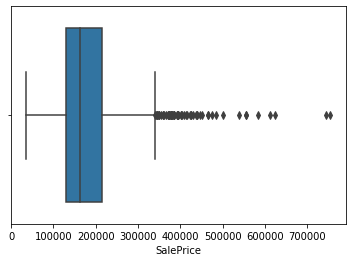

In [255]:
 sns.boxplot(y_train);

We have quite many outliers towards the top, i.e. extremely expensive housings. The box and whisker plot confirmed the skewness of the target variable and gave extra insight on the frequency of outliers. There are many, therefore we surely shouldn't touch them: we hope the model will be able to identify rules that predict a housing to be in the extreme expensive range. 

### 3.2) Multivariate Analysis

#### 3.2.1) Correlation Analysis

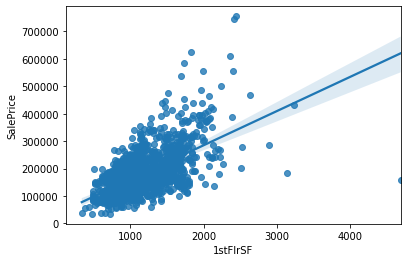

In [288]:
sns.regplot(x='1stFlrSF', y='SalePrice', data=pd.concat([X_train,y_train], axis=1));

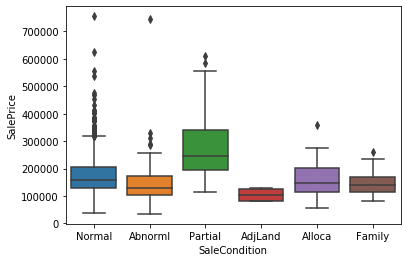

In [294]:
sns.boxplot(x='SaleCondition', y='SalePrice', data=pd.concat([X_train,y_train], axis=1));

Instead of plotting the whole correlation matrix (which would be huge and difficult to interpret), let's just focus on the top 10 features that have the most positive and the most negative correlation with *SalePrice*:

In [381]:
df_train_corr = df_train.corr(method='pearson')
# fig = plt.figure(figsize=(20,23))
# ax = sns.heatmap(df_train_corr, xticklabels=df_train_corr.columns, annot=True, fmt='.2f', cbar=False);

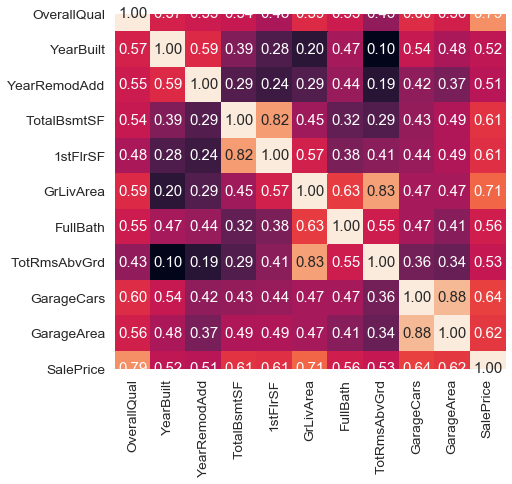

In [447]:
fig = plt.figure(figsize=(7,7))
corrmat = df_train.corr()
cols = corrmat[corrmat['SalePrice'] > 0.5]['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [467]:
highest_corr_features = corrmat[corrmat['SalePrice'] > 0.5]['SalePrice'].drop('SalePrice').sort_values(ascending=False).index.tolist()
highest_corr_features

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']

As we can see from this heatmap, the following features correlate the most positively with *SalePrice*:
 * *OverallQual*: Overall quality of the housing has a logically strong positive correlation with price,
 * *GrLivArea*, *TotalBsmtSF*, *1stFlrSF*: these all refer to the size of the housing, hence the strong positive correlation is understandable,
 * *GarageCars* and *GarageArea*: both refer to the size and spatiousness of the garage, clearly that has a positive correlation with pricing as well,
 * *TotRmsAbvGrd*: this refers to the number of (non-basement) rooms, hence again referring to the size or spatiousness of the housing,
 * *YearBuilt*: logically, newer houses tend to be higher priced, although this correlation is visibly much weaker than those referring to quality or living area since old buildings might often be refurbished and very luxurious
 * *FullBath*: slightly surprisingly, the number of bathrooms have a quite strong positive correlation with sales price as well. 
 
Side note: This latter is the only one I find somewhat surprising. In my opinion, the reason might be cultural. The dataset was collected in the US where large, multi-storey, detached houses are much more common than in my region (Central Europe) where majority of people live in apartment blocks. In a multi-storey family home, especially in an older building where staircases are narrow, it might indeed be logical that having a minimum of one bathroom per floor has a positive impact on the price of the housing.

We have investigated the most positively correlated features. How about the most negative ones? Are there any features that are strongly negatively correlated with price? 

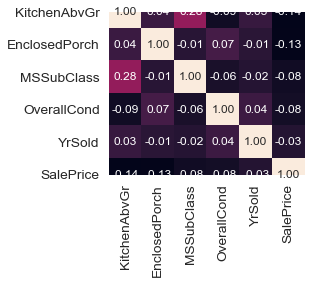

In [454]:
fig = plt.figure(figsize=(3.5,3.5))
corrmat = df_train.corr()
cols = corrmat.nsmallest(5, 'SalePrice')['SalePrice'].index.tolist() + ['SalePrice']
cm = np.corrcoef(df_train[cols].values.T)
hm = sns.heatmap(cm, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols, xticklabels=cols)

As we see, there are none. The most negatively correlated features with correlation scores of -0.14 and -0.13 are for the *KitchenAbvGr* and *EnclosedPorch* which refer to the number of (non-basement) kitchens and the area of enclosed porch area respectively. It's not logical that any of these would have a negative impact on *SalePrice* and luckily, these correlation values are not to be considered significant.

We can therefore conclude that there are no features that negatively correlate with *SalePrice* and there are 10 features that are positively correlated with a correlation coefficient above 0.5.

Now that we know what the most relevant features are, let's plot them all in a pairplot. The pairplot will allow us to visually see how individual features relate to the target variable and what the distribution of these individual features look like.

c:\users\csibi\appdata\local\programs\python\python37\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


ValueError: If using all scalar values, you must pass an index

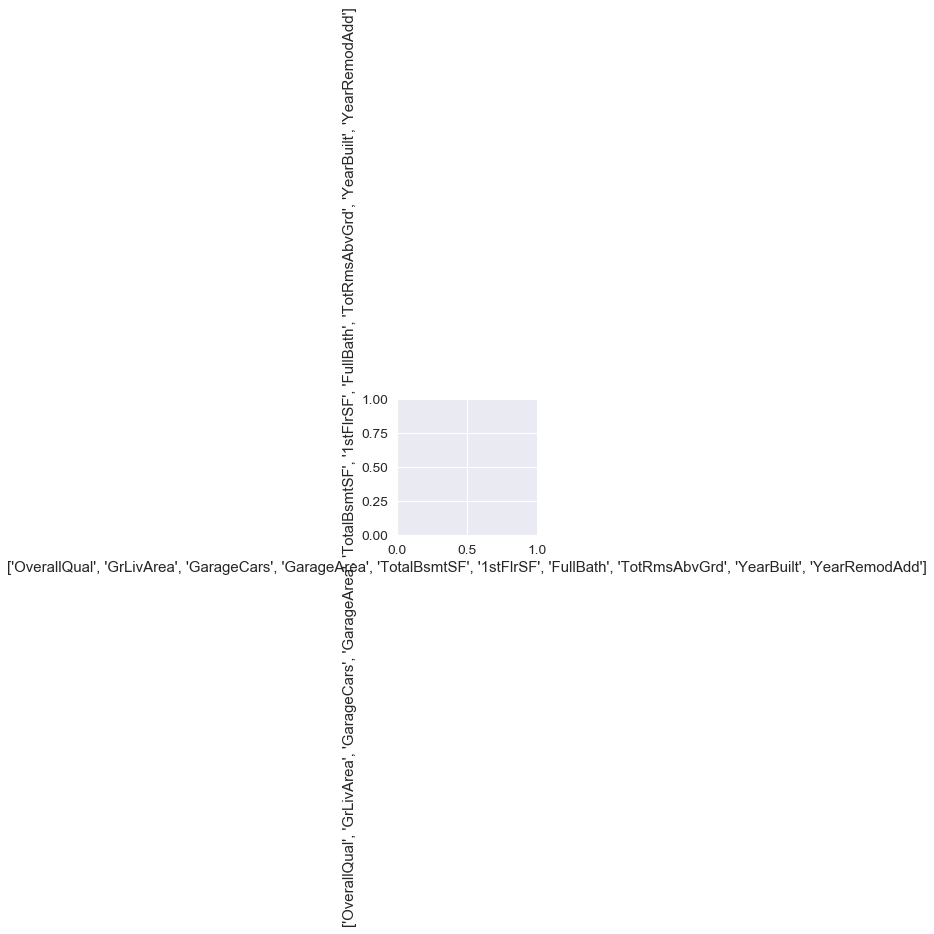

In [468]:
sns.pairplot(df_train, vars=[highest_corr_features], kind='reg');